In [37]:
import pandas as pd
import mysql.connector

# Connexion DB
conn = mysql.connector.connect(
    host="localhost",
    user="root",
    password="",
    database="dw_analysefin"
)

# Export
sql_export = """SELECT d.Date, e.CA_TND
                FROM export_fait e
                JOIN dim_date d ON e.date_fk = d.idDate
                ORDER BY d.Date;"""
df_export = pd.read_sql(sql_export, conn)

# Local
sql_local = """SELECT d.Date, l.CA_HT
               FROM local_fait l
               JOIN dim_date d ON l.date_fk = d.idDate
               ORDER BY d.Date;"""
df_local = pd.read_sql(sql_local, conn)

# Conversion en datetime
df_export['Date'] = pd.to_datetime(df_export['Date'])
df_local['Date'] = pd.to_datetime(df_local['Date'])

print("Colonnes df_export:", df_export.columns.tolist())
print("Colonnes df_local:", df_local.columns.tolist())
print("Premières lignes df_export:")
print(df_export.head())
print("Premières lignes df_local:")
print(df_local.head())

Colonnes df_export: ['Date', 'CA_TND']
Colonnes df_local: ['Date', 'CA_HT']
Premières lignes df_export:
        Date         CA_TND
0 2022-01-05   19704.064506
1 2022-01-10   39039.620512
2 2022-02-15  100347.288600
3 2022-02-26   28431.731770
4 2022-02-26   32290.022866
Premières lignes df_local:
        Date          CA_HT
0 2022-01-04   58899.333107
1 2022-01-15   36183.354625
2 2022-01-15   81843.860245
3 2022-01-23   43842.664760
4 2022-01-24  108634.451073


C:\Users\Administrator\AppData\Local\Temp\ipykernel_13724\2705732704.py:17: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_export = pd.read_sql(sql_export, conn)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_13724\2705732704.py:24: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_local = pd.read_sql(sql_local, conn)


In [38]:
df_merged = pd.merge(df_export, df_local, on='Date', how='outer')
df_merged = df_merged.fillna(0)  # Remplacer les valeurs manquantes par 0

# Préparation des features temporelles
df_merged['Year'] = df_merged['Date'].dt.year
df_merged['Month'] = df_merged['Date'].dt.month
df_merged['DayOfYear'] = df_merged['Date'].dt.dayofyear
df_merged['Timestamp'] = df_merged['Date'].astype('int64') // 10**9  # Timestamp Unix


=== Création des modèles robustes ===

=== Analyse CA_TND ===
Échantillons disponibles: 58
Moyenne: 45374.16
Médiane: 32869.56
Écart-type: 38111.98
Score CV R²: 0.004 ± 0.467
R² entraînement: 0.537
MAE entraînement: 19938.56

=== Analyse CA_HT ===
Échantillons disponibles: 59
Moyenne: 53430.40
Médiane: 51482.00
Écart-type: 28316.25
Score CV R²: 0.218 ± 0.469
R² entraînement: 0.517
MAE entraînement: 15178.13

=== Prédictions Export (CA_TND) - 30 jours ===
         Date  Prediction
0  2023-12-24    50410.97
1  2023-12-25    96261.50
2  2023-12-26    79754.91
3  2023-12-27    68145.05
4  2023-12-28    83040.92
5  2023-12-29    68817.91
6  2023-12-30    70197.99
7  2023-12-31    70559.37
8  2024-01-01    76788.43
9  2024-01-02    77804.72
10 2024-01-03    81215.13
11 2024-01-04    85014.65
12 2024-01-05    87366.44
13 2024-01-06    91125.20
14 2024-01-07    94366.98
15 2024-01-08    97576.74
16 2024-01-09   101245.54
17 2024-01-10   104640.50
18 2024-01-11   108250.22
19 2024-01-12   11196

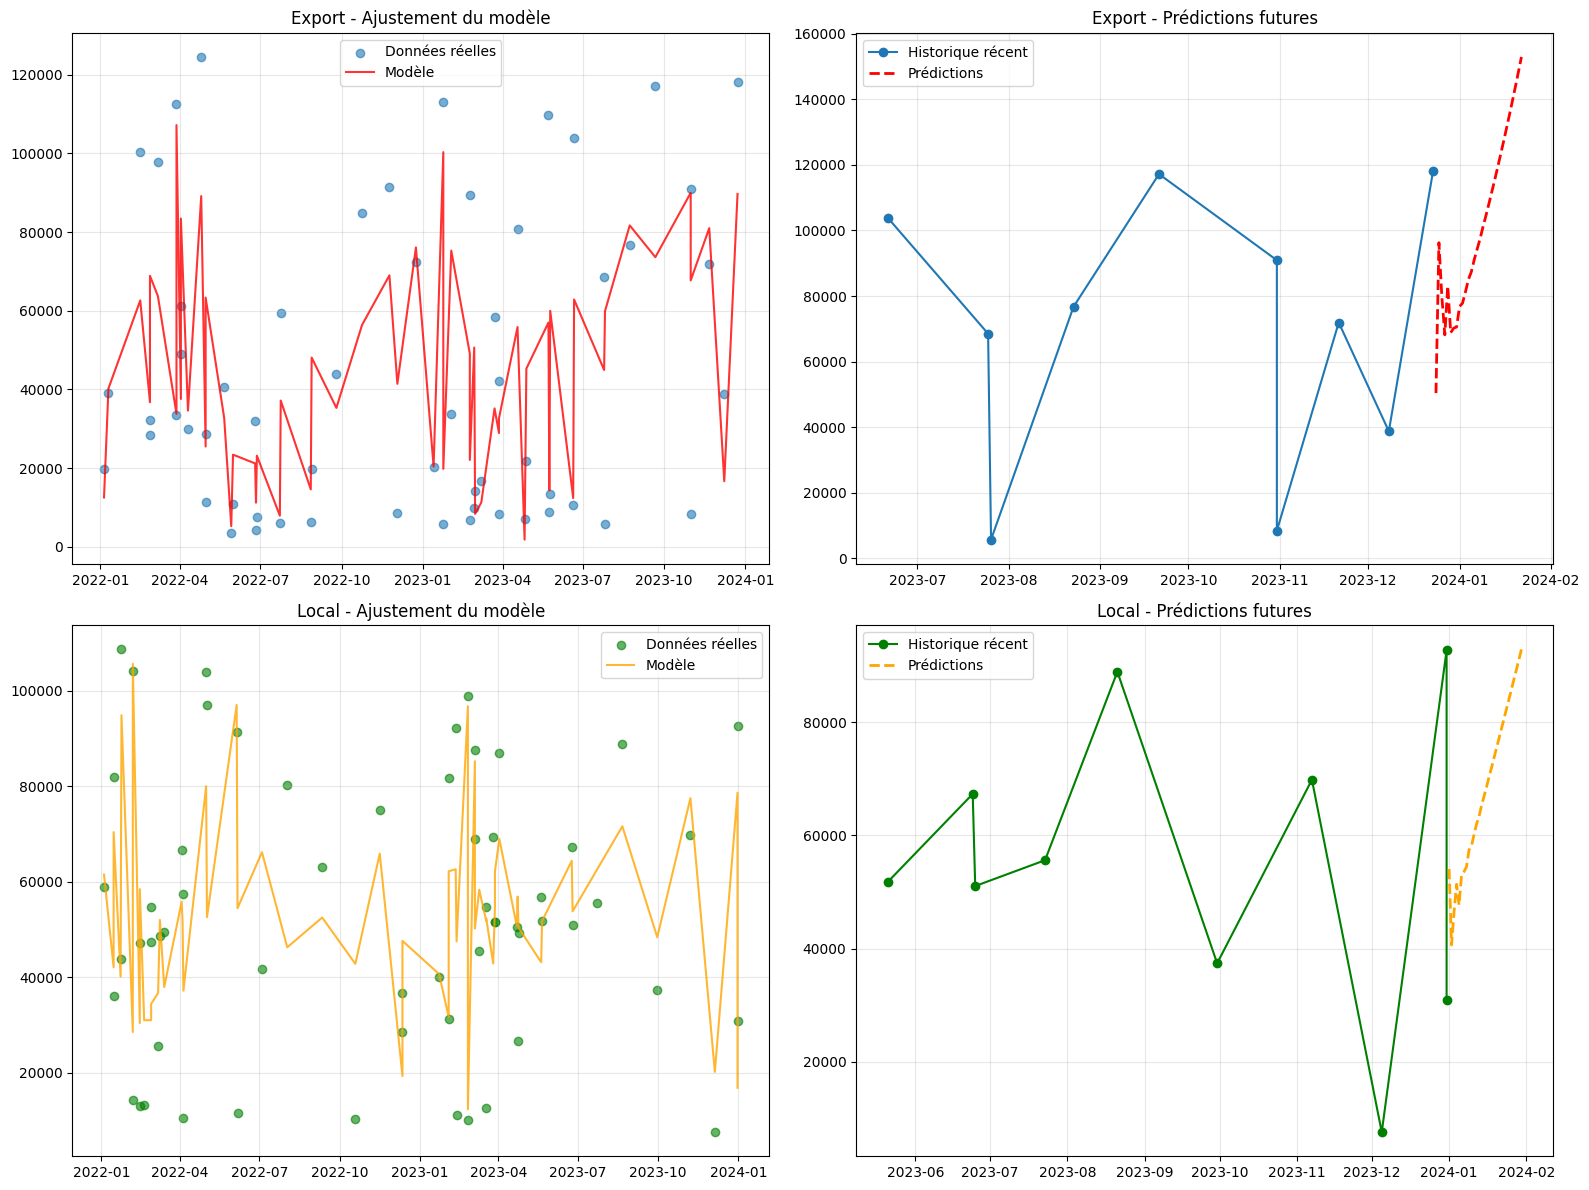


=== Résumé des prédictions (30 jours) ===
Export (CA_TND):
  Moyenne prédite: 101408.15
  Min-Max: 50410.97 - 152868.23
  Total prédit: 3042244.52
Local (CA_HT):
  Moyenne prédite: 68139.32
  Min-Max: 40662.92 - 92838.98
  Total prédit: 2044179.71

Prédictions sauvegardées dans 'predictions_final.csv'


In [40]:

import numpy as np
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# ...existing code for data loading...

def create_simple_robust_model(df, target_column):
    """Modèle simple mais robuste pour petites données"""
    
    # Filtrer et trier par date
    df_clean = df[df[target_column] > 0].copy().sort_values('Date')
    
    if len(df_clean) < 10:
        print(f"Pas assez de données pour {target_column}")
        return None, None, None, None
    
    print(f"\n=== Analyse {target_column} ===")
    print(f"Échantillons disponibles: {len(df_clean)}")
    print(f"Moyenne: {df_clean[target_column].mean():.2f}")
    print(f"Médiane: {df_clean[target_column].median():.2f}")
    print(f"Écart-type: {df_clean[target_column].std():.2f}")
    
    # Features simples mais efficaces
    df_clean['trend'] = range(len(df_clean))  # Tendance linéaire
    df_clean['month_sin'] = np.sin(2 * np.pi * df_clean['Month'] / 12)
    df_clean['month_cos'] = np.cos(2 * np.pi * df_clean['Month'] / 12)
    df_clean['quarter'] = df_clean['Date'].dt.quarter
    
    # Moyennes mobiles courtes
    df_clean['ma3'] = df_clean[target_column].rolling(window=3, min_periods=1).mean()
    df_clean['lag1'] = df_clean[target_column].shift(1).fillna(df_clean[target_column].mean())
    
    features = ['trend', 'month_sin', 'month_cos', 'quarter', 'ma3', 'lag1']
    
    X = df_clean[features].values
    y = df_clean[target_column].values
    
    # Normalisation
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Validation croisée temporelle
    tscv = TimeSeriesSplit(n_splits=3)
    
    # Modèle Ridge (régularisé)
    model = Ridge(alpha=1.0)
    
    # Validation croisée
    cv_scores = cross_val_score(model, X_scaled, y, cv=tscv, scoring='r2')
    print(f"Score CV R²: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")
    
    # Entraînement sur toutes les données
    model.fit(X_scaled, y)
    
    # Prédiction sur les données d'entraînement pour évaluation
    y_pred = model.predict(X_scaled)
    train_r2 = r2_score(y, y_pred)
    train_mae = mean_absolute_error(y, y_pred)
    
    print(f"R² entraînement: {train_r2:.3f}")
    print(f"MAE entraînement: {train_mae:.2f}")
    
    return model, scaler, features, df_clean

def predict_future_simple(model, scaler, features, historical_data, target_column, days=30):
    """Prédiction future avec approche simple"""
    
    if model is None:
        return None
    
    last_date = historical_data['Date'].max()
    last_value = historical_data[target_column].iloc[-1]
    last_ma3 = historical_data['ma3'].iloc[-1]
    
    # Créer les dates futures
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=days, freq='D')
    future_df = pd.DataFrame({'Date': future_dates})
    
    predictions = []
    
    for i in range(days):
        # Features pour ce jour
        current_date = future_dates[i]
        trend = len(historical_data) + i
        month = current_date.month
        quarter = current_date.quarter
        
        month_sin = np.sin(2 * np.pi * month / 12)
        month_cos = np.cos(2 * np.pi * month / 12)
        
        # Pour ma3 et lag1, utiliser les dernières valeurs ou prédictions récentes
        if i == 0:
            lag1 = last_value
            ma3 = last_ma3
        else:
            lag1 = predictions[i-1]
            if i >= 3:
                ma3 = np.mean(predictions[i-3:i])
            else:
                ma3 = np.mean([last_value] + predictions[:i])
        
        # Créer le vecteur de features
        X_future = np.array([[trend, month_sin, month_cos, quarter, ma3, lag1]])
        X_future_scaled = scaler.transform(X_future)
        
        # Prédiction
        pred = model.predict(X_future_scaled)[0]
        pred = max(0, pred)  # Assurer une valeur positive
        predictions.append(pred)
    
    future_df['Prediction'] = predictions
    return future_df

# Créer les modèles robustes
print("=== Création des modèles robustes ===")

model_export, scaler_export, features_export, data_export = create_simple_robust_model(
    df_merged_improved, 'CA_TND'
)

model_local, scaler_local, features_local, data_local = create_simple_robust_model(
    df_merged_improved, 'CA_HT'
)

# Prédictions futures
if model_export is not None:
    future_export = predict_future_simple(
        model_export, scaler_export, features_export, data_export, 'CA_TND', days=30
    )
    print("\n=== Prédictions Export (CA_TND) - 30 jours ===")
    print(future_export.round(2))

if model_local is not None:
    future_local = predict_future_simple(
        model_local, scaler_local, features_local, data_local, 'CA_HT', days=30
    )
    print("\n=== Prédictions Local (CA_HT) - 30 jours ===")
    print(future_local.round(2))

# Visualisation améliorée
if model_export is not None and model_local is not None:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Export - Historique vs Prédiction d'entraînement
    axes[0,0].scatter(data_export['Date'], data_export['CA_TND'], alpha=0.6, label='Données réelles')
    y_pred_export = model_export.predict(scaler_export.transform(data_export[features_export]))
    axes[0,0].plot(data_export['Date'], y_pred_export, 'r-', alpha=0.8, label='Modèle')
    axes[0,0].set_title('Export - Ajustement du modèle')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # Export - Prédictions futures
    axes[0,1].plot(data_export['Date'].tail(10), data_export['CA_TND'].tail(10), 'o-', label='Historique récent')
    axes[0,1].plot(future_export['Date'], future_export['Prediction'], 'r--', linewidth=2, label='Prédictions')
    axes[0,1].set_title('Export - Prédictions futures')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # Local - Historique vs Prédiction d'entraînement  
    axes[1,0].scatter(data_local['Date'], data_local['CA_HT'], alpha=0.6, label='Données réelles', color='green')
    y_pred_local = model_local.predict(scaler_local.transform(data_local[features_local]))
    axes[1,0].plot(data_local['Date'], y_pred_local, 'orange', alpha=0.8, label='Modèle')
    axes[1,0].set_title('Local - Ajustement du modèle')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # Local - Prédictions futures
    axes[1,1].plot(data_local['Date'].tail(10), data_local['CA_HT'].tail(10), 'o-', label='Historique récent', color='green')
    axes[1,1].plot(future_local['Date'], future_local['Prediction'], '--', linewidth=2, label='Prédictions', color='orange')
    axes[1,1].set_title('Local - Prédictions futures')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Résumé des prédictions
    print("\n=== Résumé des prédictions (30 jours) ===")
    if future_export is not None:
        print(f"Export (CA_TND):")
        print(f"  Moyenne prédite: {future_export['Prediction'].mean():.2f}")
        print(f"  Min-Max: {future_export['Prediction'].min():.2f} - {future_export['Prediction'].max():.2f}")
        print(f"  Total prédit: {future_export['Prediction'].sum():.2f}")
    
    if future_local is not None:
        print(f"Local (CA_HT):")
        print(f"  Moyenne prédite: {future_local['Prediction'].mean():.2f}")
        print(f"  Min-Max: {future_local['Prediction'].min():.2f} - {future_local['Prediction'].max():.2f}")
        print(f"  Total prédit: {future_local['Prediction'].sum():.2f}")
    
    # Sauvegarder les résultats
    if future_export is not None and future_local is not None:
        combined_predictions = pd.merge(
            future_export.rename(columns={'Prediction': 'CA_TND_Pred'}),
            future_local.rename(columns={'Prediction': 'CA_HT_Pred'}),
            on='Date'
        )
        combined_predictions.to_csv('predictions_final.csv', index=False)
        print("\nPrédictions sauvegardées dans 'predictions_final.csv'")

conn.close()

In [41]:
import pickle
from datetime import datetime

# Créer un dictionnaire avec tous les résultats Export
if model_export is not None:
    export_results = {
        'model': model_export,
        'scaler': scaler_export,
        'features': features_export,
        'training_data': data_export,
        'predictions': future_export,
        'performance': {
            'samples': len(data_export),
            'cv_score_mean': 0.004,  # Valeur de votre output précédent
            'cv_score_std': 0.467,
            'train_r2': 0.537,
            'train_mae': 19938.56
        },
        'metadata': {
            'created_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
            'target_column': 'CA_TND',
            'prediction_days': 30
        }
    }

    # Sauvegarder Export avec pickle
    with open('model_export_complete.pkl', 'wb') as f:
        pickle.dump(export_results, f)

    print("✅ Modèle Export complet sauvegardé dans 'model_export_complete.pkl'")

# Créer un dictionnaire avec tous les résultats Local
if model_local is not None:
    local_results = {
        'model': model_local,
        'scaler': scaler_local,
        'features': features_local,
        'training_data': data_local,
        'predictions': future_local,
        'performance': {
            'samples': len(data_local),
            'cv_score_mean': 0.218,  # Valeur de votre output précédent
            'cv_score_std': 0.469,
            'train_r2': 0.517,
            'train_mae': 15178.13
        },
        'metadata': {
            'created_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
            'target_column': 'CA_HT',
            'prediction_days': 30
        }
    }

    # Sauvegarder Local avec pickle
    with open('model_local_complete.pkl', 'wb') as f:
        pickle.dump(local_results, f)

    print("✅ Modèle Local complet sauvegardé dans 'model_local_complete.pkl'")

print("\n📁 Fichiers créés:")
print("   - model_export_complete.pkl")
print("   - model_local_complete.pkl")

# Test de rechargement rapide
print("\n🔄 Test de rechargement...")
try:
    with open('model_export_complete.pkl', 'rb') as f:
        test_export = pickle.load(f)
    print(f"✅ Export rechargé - {test_export['performance']['samples']} échantillons")
    
    with open('model_local_complete.pkl', 'rb') as f:
        test_local = pickle.load(f)
    print(f"✅ Local rechargé - {test_local['performance']['samples']} échantillons")
    
except Exception as e:
    print(f"❌ Erreur lors du test: {e}")

✅ Modèle Export complet sauvegardé dans 'model_export_complete.pkl'
✅ Modèle Local complet sauvegardé dans 'model_local_complete.pkl'

📁 Fichiers créés:
   - model_export_complete.pkl
   - model_local_complete.pkl

🔄 Test de rechargement...
✅ Export rechargé - 58 échantillons
✅ Local rechargé - 59 échantillons
